<a href="https://colab.research.google.com/github/kowalcorp/Neural_Networks_from_scrach_python_numpy/blob/main/conv_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on Youtube video titled: Deep Learning 54: CNN_6 - Implementation of CNN from Scratch in Python

https://www.youtube.com/watch?v=0zbhg79i_Bs&t=409s

In [1]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
#from tensorflow.examples.tutorials.mnist import input_data

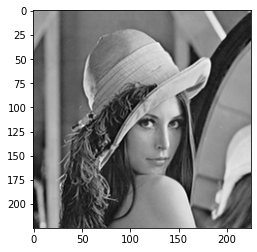

(225, 225)

In [2]:
img = cv2.imread('Lenna.png', cv2.IMREAD_GRAYSCALE)/255
plt.imshow(img, cmap = 'gray')
plt.show()
img.shape

In [3]:
class Conv_op:
  def __init__(self, num_filters, filter_size):
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)/(filter_size * filter_size)

  def image_region(self,image): #generator function
    height, width = image.shape
    self.image = image
    for j in range(height - self.filter_size + 1):
      for k in range(width - self.filter_size +1):
        image_patch = image[j:(j+self.filter_size),k:(k+self.filter_size)]
        yield image_patch, j, k

  def forward_prop(self,image):
    height, width = image.shape
    conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size+1, self.num_filters))
    for image_path, i,j in self.image_region(image):
      conv_out[i,j]= np.sum(image_path * self.conv_filter, axis=(1,2))
    return conv_out

  def back_prop(self, dL_dout, learning_rate):
    dL_dF_params = np.zeros(self.conv_filter.shape)
    for image_patch, i,j in self.image_region(self.image):
      for k in range(self.num_filters):
        dL_dF_params[k] += image_patch*dL_dout[i,j,k]

    #filter params update
    self.conv_filter -= learning_rate*dL_dF_params
    return dL_dF_params

In [4]:
conn = Conv_op(18,7)
out = conn.forward_prop(img)
out.shape

(219, 219, 18)

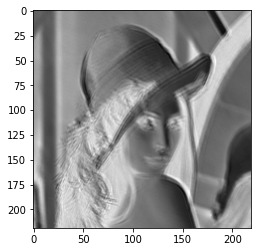

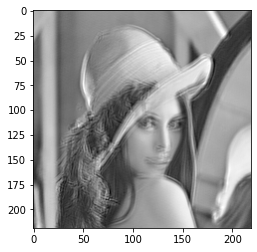

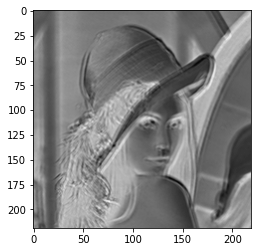

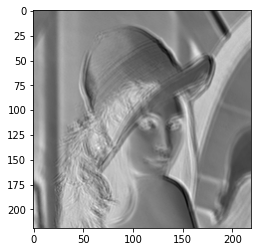

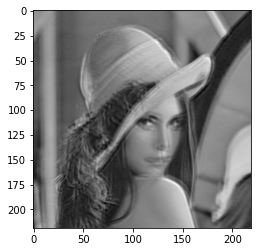

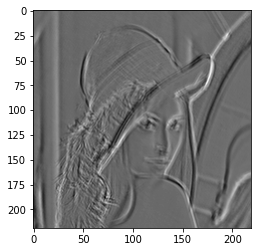

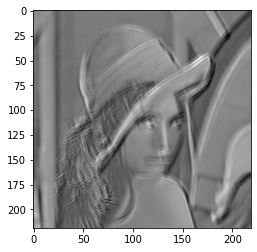

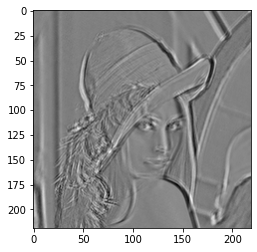

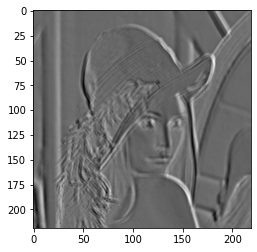

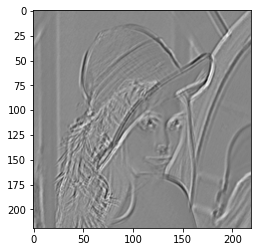

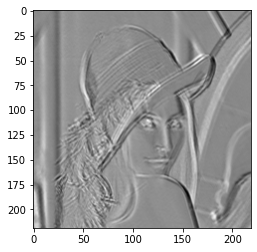

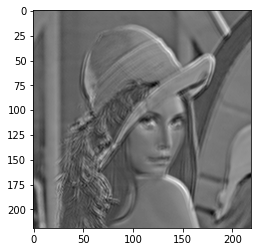

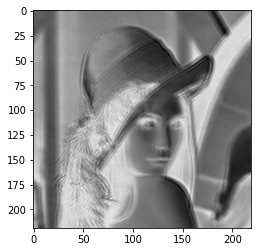

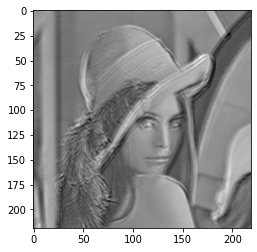

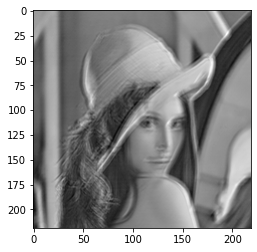

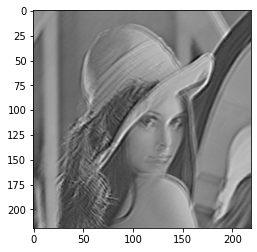

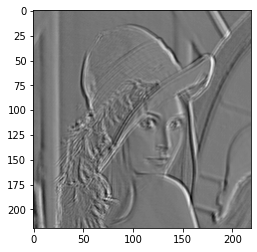

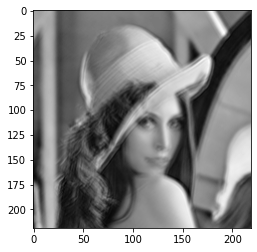

In [5]:
for i in range(0,18):
  plt.imshow(out[:,:,i],cmap='gray')
  plt.show()

In [6]:
class Max_Pool:
  def __init__(self, filter_size):
    self.filter_size = filter_size

  def image_region(self, image):
    new_height = image.shape[0] // self.filter_size
    new_width = image.shape[1] // self.filter_size
    self.image = image

    for i in range(new_height):
      for j in range(new_width):
        image_patch = image[(i*self.filter_size):(i*self.filter_size + self.filter_size), (j*self.filter_size):(j*self.filter_size + self.filter_size)]
        yield image_patch, i, j

  def forward_prop(self, image):
    height, width, num_filters = image.shape
    output = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))

    for image_patch, i, j in self.image_region(image):
      output[i,j] = np.amax(image_patch, axis = (0,1))

    return output


  def back_prop(self, dL_dout):
    dL_dmax_pool = np.zeros(self.image.shape)
    for image_patch, i, j in self.image_region(self.image):
      height, width, num_filters = image_patch.shape
      maximum_val = np.amax(image_patch,axis = (0,1))

      for i1 in range(height):
        for j1 in range(width):
          for k1 in range(num_filters):
            if image_patch[i1,j1,k1] == maximum_val[k1]:
              dL_dmax_pool[i*self.filter_size + i1, j*self.filter_size + j1, k1]=dL_dout[i,j,k1]
      return dL_dmax_pool

In [7]:
conn2 = Max_Pool(4)
out2= conn2.forward_prop(out)
out2.shape

(54, 54, 18)

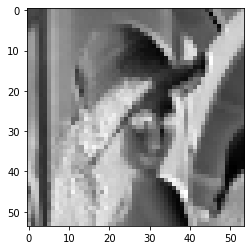

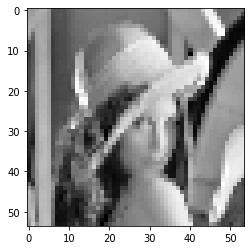

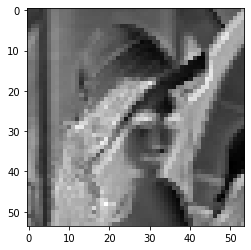

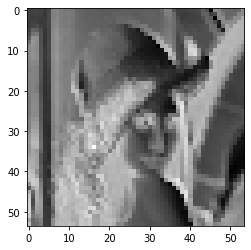

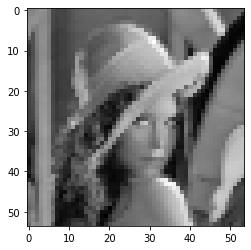

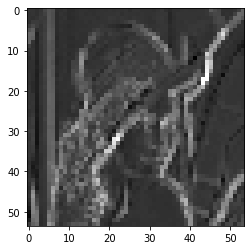

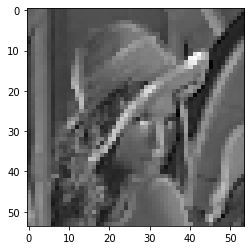

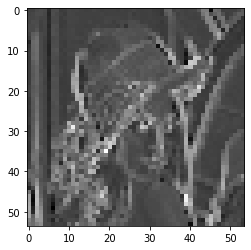

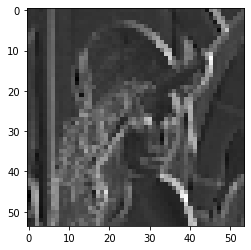

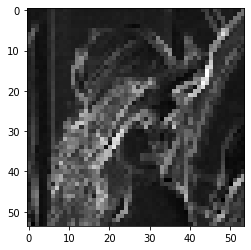

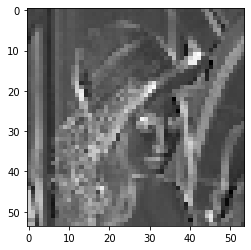

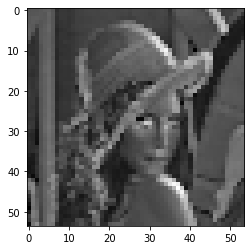

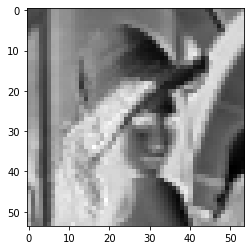

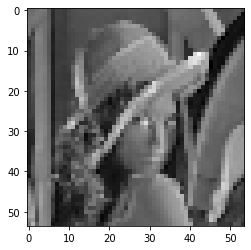

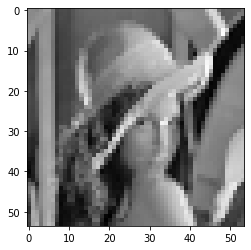

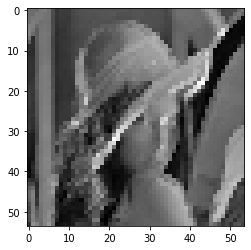

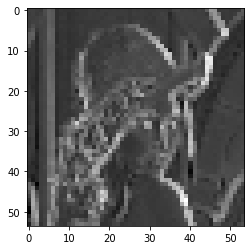

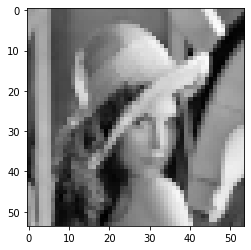

In [8]:
for i in range(0,18):
  plt.imshow(out2[:,:,i],cmap='gray')
  plt.show()

In [9]:
class Softmax:
  def __init__(self, input_node, softmax_node):
    self.weight = np.random.randn(input_node, softmax_node)/input_node
    self.bias = np.zeros(softmax_node)

  def forward_prop(self, image):
    self.orig_im_shape = image.shape #used in backprop
    image_modified = image.flatten()
    self.modified_input = image_modified #to be used in backprop
    output_val = np.dot(image_modified, self.weight) + self.bias
    self.out = output_val
    exp_out = np.exp(output_val)
    return exp_out/np.sum(exp_out, axis=0)

  def back_prop(self, dL_dout, learning_rate):
    for i, grad in enumerate(dL_dout):
      if grad ==0:
        continue

      transformation_eq = np.exp(self.out)
      S_total = np.sum(transformation_eq)

      #gradients with respect to out (z)
      dy_dz = -transformation_eq[i]*transformation_eq / (S_total **2)
      dy_dz[i] = transformation_eq[i]*(S_total -  transformation_eq[i]) / (S_total **2)


      #gradients of totals against weights/biases/input
      dz_dw =  self.modified_input
      dz_db = 1
      dz_d_inp = self.weight

      #gradients of loss against totals
      dL_dz = grad * dy_dz

      #gradients of loss against weights/biases/input
      dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
      dL_db = dL_dz * dz_db
      dL_d_inp = dz_d_inp @ dL_dz

    self.weight -= learning_rate *dL_dw
    self.bias -= learning_rate * dL_db

    return dL_d_inp.reshape(self.orig_im_shape)


In [11]:
conn3= Softmax(54*54*18,10)
out3 = conn3.forward_prop(out2)
print(out3)

[0.10000456 0.0999357  0.10003093 0.10003953 0.09997372 0.10003842
 0.09995347 0.10006549 0.09996291 0.09999525]


In [12]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
train_images = X_train[:1500]
train_labels = y_train[:1500]
test_images = X_test[:1500]
test_labels = y_test[:1500]

conv = Conv_op(8,3)
pool = Max_Pool(2)
softmax = Softmax(13*13*8, 10)

def cnn_forward_prop(image, label):
  out_p = conv.forward_prop((image /255) -0.5)
  out_p = pool.forward_prop(out_p)
  out_p = softmax.forward_prop(out_p)

  #calculate cross-entropy loss and accuracy
  cross_ent_loss = -np.log(out_p[label])
  accuracy_eval = 1 if np.argmax(out_p) == label else 0

  return out_p, cross_ent_loss, accuracy_eval

def training_cnn(image, label, learn_rate =0.005):

  #forward
  out, loss, acc = cnn_forward_prop(image, label)

  #calculate ininital gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  #brackprop
  grad_back = softmax.back_prop(gradient, learn_rate)
  grad_back = pool.back_prop(grad_back)
  grad_back = conv.back_prop(grad_back, learn_rate)

  return loss, acc

11493376/11490434 [==============================] - 0s 0us/step


In [13]:
#training cnn
for epoch1 in range(4):
  print('Epoch %d ->'% (epoch1 +1))

  #shuffle the training data
  shuffle_data = np.random.permutation(len(train_images))
  train_images = train_images[shuffle_data]
  train_labels = train_labels[shuffle_data]

  #training the CNN
  loss = 0.0
  num_correct = 0

  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 100 == 0:
      print('%d steps out of 100 steps: Average Loss %.3f and Accuracy: %d%%' %(i+1, loss/100, num_correct))
      loss = 0
      num_correct = 0

    l1, accu = training_cnn(im, label)
    loss += l1

    num_correct +=accu



Epoch 1 ->
1 steps out of 100 steps: Average Loss 0.000 and Accuracy: 0%
101 steps out of 100 steps: Average Loss 2.265 and Accuracy: 15%
201 steps out of 100 steps: Average Loss 2.235 and Accuracy: 26%
301 steps out of 100 steps: Average Loss 2.209 and Accuracy: 28%
401 steps out of 100 steps: Average Loss 2.136 and Accuracy: 42%
501 steps out of 100 steps: Average Loss 2.088 and Accuracy: 55%
601 steps out of 100 steps: Average Loss 2.079 and Accuracy: 48%
701 steps out of 100 steps: Average Loss 2.050 and Accuracy: 57%
801 steps out of 100 steps: Average Loss 1.988 and Accuracy: 67%
901 steps out of 100 steps: Average Loss 1.933 and Accuracy: 67%
1001 steps out of 100 steps: Average Loss 1.903 and Accuracy: 67%
1101 steps out of 100 steps: Average Loss 1.856 and Accuracy: 69%
1201 steps out of 100 steps: Average Loss 1.884 and Accuracy: 58%
1301 steps out of 100 steps: Average Loss 1.852 and Accuracy: 60%
1401 steps out of 100 steps: Average Loss 1.783 and Accuracy: 70%
Epoch 2 ->
1

In [15]:
#testing the cnn

print('**testing phase')
loss = 0
num_correct = 0

for im, label in zip(test_images, test_labels):
  _, l1, accu = cnn_forward_prop(im, label)
  loss += l1
  num_correct += accu

num_test = len(test_images)
print('Test Loss:', loss /num_test)
print('Test accuracy:', num_correct / num_test)

**testing phase
Test Loss: 1.1976714704838274
Test accuracy: 0.73
